In [380]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from moviepy.editor import *
import numpy as np
import pandas as pd
from moviepy.config import change_settings
import cv2
import shutil
import os


In [381]:
# URL to the public runalyze site to scan for the video
runnersite = "https://runalyze.com/athlete/Schrottie" # The URL which would be parsed

# If ImageMagick cannot be installed on the PC due to a lack of appropriate
# authorizations, simply download a portable version and then adjust the path here!
change_settings({"IMAGEMAGICK_BINARY": r"C:\Users\24007120\Documents\Imagemagick\convert.exe"})

# Files
chart_file_pic = 'tmp/chart.png' # Temporary chartpic
save_chart = True # If True a PNG is saved in movies-dircetory

# Video
#width, height = 1920, 1080 # Video resolution
duration_per_row = 2  # Duration for displaying each row of data in seconds
fade_duration = 1  # Fade duration in seconds
final_duration = 7  # Duration of the final display in seconds
video_start_graphic = None # optional: initial pic (fullscreen) in video
start_clip_duration = 5 # Duration of (optional) start pic
video_end_graphic = None # optional: closing pic (fullscreen) in video
end_clip_duration = 5 # Duration of (optional) closing pic
fps = 30 # frames per second

# Video text style
font = cv2.FONT_HERSHEY_TRIPLEX
font_scale = 3
font_color = (107, 82, 68)  # gray-blue
sum_font_color = (79, 40, 163) # red
font_thickness = 7

In [382]:
# Function for retrieving the website and extracting the relevant information
def extract_activity_data():
    response = requests.get(runnersite)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    activities = []
    today = datetime.today().strftime('%d.%m.%Y')
    
    # Find all lines with running activities
    activity_rows = soup.find_all('tr', class_='r')
    
    data = {
        'date': [],
        'a_type': [],
        'r_type': [],
        'distance': [],
        'duration': [],
        'pace': []
    }
    
    current_date = None
    
    for row in activity_rows:
        cols = row.find_all('td')
        
        if cols:
            date_cell = cols[1].text.strip()
            if date_cell == '': # completely empty means that it is not the first activity of the day
                offset = 0
            else:
                offset = 1
                new_date = date_cell.split()[0] + '.' + str(datetime.today().year)
                # Remember the date so that it can be used in lines without a date
                if new_date and new_date != current_date:
                    current_date = new_date
                    
            if row.find('i', class_='icons8-Running'):
                rt_str = cols[3 + offset].text.strip() if len(cols) > 3 + offset else ''
                distance_str = cols[4 + offset].text.strip().split()[0].replace(',', '.') if len(cols) > 4 + offset else ''
                duration_str = cols[5 + offset].text.strip() if len(cols) > 5 + offset else ''
                pace_str = cols[6 + offset].text.strip() if len(cols) > 6 + offset else ''
                
                # Check that the current values are not empty
                if distance_str and duration_str and pace_str:
                    activities.append({'date': current_date, 'a_type': 'run', 'r_type': rt_str, 'distance': distance_str, 'duration': duration_str, 'pace': pace_str})
                else:
                    # Use the previous date if the current values are empty
                    if data['date']:
                        activities.append({'date': data['date'][-1], 'a_type': 'run', 'r_type': rt_str, 'distance': distance_str, 'duration': duration_str, 'pace': pace_str})
    
    df = pd.DataFrame(activities)
    df = df[df['a_type'] == 'run'] # Filter by activity type "run"
    
    # Clean up dataframe so that data types fit and do not cause errors later
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['pace'] = df['pace'].str.replace("/km", "")  # Remove "/km"
    df['duration'] = pd.to_timedelta(df['duration'])
    df['duration_minutes'] = df['duration'].dt.total_seconds() / 60

    # Set new name for the final videoclip and the chartpic
    min_date_str = df['date'].min().replace('.', '')  # Format date without dots
    max_date_str = df['date'].max().replace('.', '')  # Format date without dots

    # Name the video file
    global final_video_clip
    final_video_clip = f"movies/activity_movie_{min_date_str}_{max_date_str}.mp4"
    global final_chart_pic
    final_chart_pic = f"movies/chart_{min_date_str}_{max_date_str}.png"

    # Give me the dataframe!
    return df

In [383]:
# Function for creating the chart
def create_chart(activities):
    # Number of lines in the dataframe
    n_rows = activities.shape[0]

    # Create a figure object with square dimensions
    fig, ax = plt.subplots(figsize=(10, 10))

    # Set the labeling of the Y-axis to "from - to"
    ax.set_ylabel(f"{activities['date'].min()} to {activities['date'].max()}")
    
    # Create a horizontal bar plot for the distance
    for i, (dist, dur, pace) in enumerate(zip(activities["distance"], activities["duration"], activities["pace"])):
        
        # Set the color for the bars
        color = mcolors.to_rgba_array(plt.cm.bone(0.3 + i * 0.3 / n_rows))

        # Paint th bars
        ax.barh(i, dist, color=color, edgecolor='black')
        
        # Format the duration so that it is not preceded by "0 days"
        dur_formatted = str(dur).split()[-1]

        # Label the bars with the distance values on the right-hand edge of the bar
        ax.text(dist, i, f"{dur_formatted} / {pace}  ", ha='right', va='center', rotation=0, color='white')

    # Set the labels of the X-axis for the distance
    ax.set_xlabel("Running distance (km)")
    
    # Remove the labels from the Y-axis
    ax.set_yticks([])

    # Set background color
    ax.set_facecolor('#fffff0')

    # Save chart as an image
    fig.savefig(chart_file_pic, bbox_inches='tight', dpi=350)  
    
    # Show the chart
    #plt.show()

In [384]:
# Function for creating the video
def create_video(df, duration_per_row=3, fade_duration=1):

    # Calculate the height of text area and image area
    text_area_height = 840
    image_area_height = 1080

    # Create the video writer object
    out = cv2.VideoWriter(final_video_clip, cv2.VideoWriter_fourcc(*'mp4v'), fps, (1080, 1920))

    # Iterate through each row in DataFrame
    for index, row in df.iterrows():

        # clip first 7 characters if duration begins with '0 days'
        duration_str = str(row['duration'])
        if duration_str[0] == '0':
            duration_str = duration_str[7:]
        # Create text for the row
        text_lines = [
            f"{row['date']}",
            f"{row['distance']} km",
            f"{duration_str}",
            f"{row['pace']} min/km"
        ]
        text = '\n'.join(text_lines)

        # Create blank frame
        frame = np.zeros((1920, 1080, 3), dtype=np.uint8)
        cv2.rectangle(frame, (0, 0), (1080, 1920), (255, 255, 255), -1)  # Fill frame with white

        # Add text to frame
        text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
        text_x = (1080 - text_size[0]) // 2
        line_height = text_size[1] * 1.5  # Increase line height by 1.5 times
        text_y = (text_area_height - line_height * len(text_lines)) // 2 + text_size[1]  # Center text vertically
        for i, line in enumerate(text_lines):
            line_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
            line_x = (1080 - line_size[0]) // 2
            line_y = int(text_y + i * line_height)  # Use adjusted line height
            cv2.putText(frame, line, (line_x, line_y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

        # Resize and add image to frame
        image_clip = cv2.imread(chart_file_pic)
        image_clip_resized = cv2.resize(image_clip, (1080, image_area_height))
        frame[text_area_height:, :] = image_clip_resized

        # Write frame to video for duration_per_row seconds
        for _ in range(int(fps * duration_per_row)):
            out.write(frame)

        # Create transition frame
        transition_frame = np.zeros((1920, 1080, 3), dtype=np.uint8)

        # Add text to transition frame
        for i, line in enumerate(text_lines):
            line_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
            line_x = (1080 - line_size[0]) // 2
            line_y = int(text_y + i * line_height)  # Use adjusted line height
            cv2.putText(transition_frame, line, (line_x, line_y), font, font_scale, font_color, font_thickness, cv2.LINE_AA)

        # Resize and add image to transition frame
        transition_frame[text_area_height:, :] = image_clip_resized
        cv2.rectangle(transition_frame, (0, 0), (1080, 840), (255, 255, 255), -1)  # Fill frame with white

        # Create alpha mask for blending
        alpha_mask = np.linspace(0, 255, int(fps * fade_duration)).astype(np.uint8)

        # Apply alpha blending for transition
        for alpha in alpha_mask:
            blended_frame = cv2.addWeighted(frame, 1 - alpha / 255, transition_frame, alpha / 255, 0)
            out.write(blended_frame)

    # Write summary clip to video
    distance_sum = df['distance'].sum()
    duration_sum = df['duration'].sum()
    pace_mean = df['pace'].apply(lambda x: datetime.strptime(x, '%M:%S')).mean().strftime('%M:%S')

    summary_text_lines = [
        "Total:",
        f"{distance_sum} km",
        f"{duration_sum}",
        f"{pace_mean} min/km" 
    ]
    summary_text = '\n'.join(summary_text_lines)
    summary_frame = np.zeros((1920, 1080, 3), dtype=np.uint8)
    cv2.rectangle(summary_frame, (0, 0), (1080, 1920), (255, 255, 255), -1)  # Fill frame with white

    for i, line in enumerate(summary_text_lines):
        line_size = cv2.getTextSize(line, font, font_scale, font_thickness)[0]
        line_x = (1080 - line_size[0]) // 2
        line_y = int(text_y + i * line_height)  # Use adjusted line height
        cv2.putText(summary_frame, line, (line_x, line_y), font, font_scale, sum_font_color, font_thickness, cv2.LINE_AA)
        
    summary_frame[text_area_height:, :] = image_clip_resized  # Use last image clip

    for _ in range(int(fps * final_duration)):
        out.write(summary_frame)

    # Release video writer object
    out.release()
    # Clean up
    if save_chart:
        shutil.move(chart_file_pic, final_chart_pic)
    else:
        os.remove(chart_file_pic)

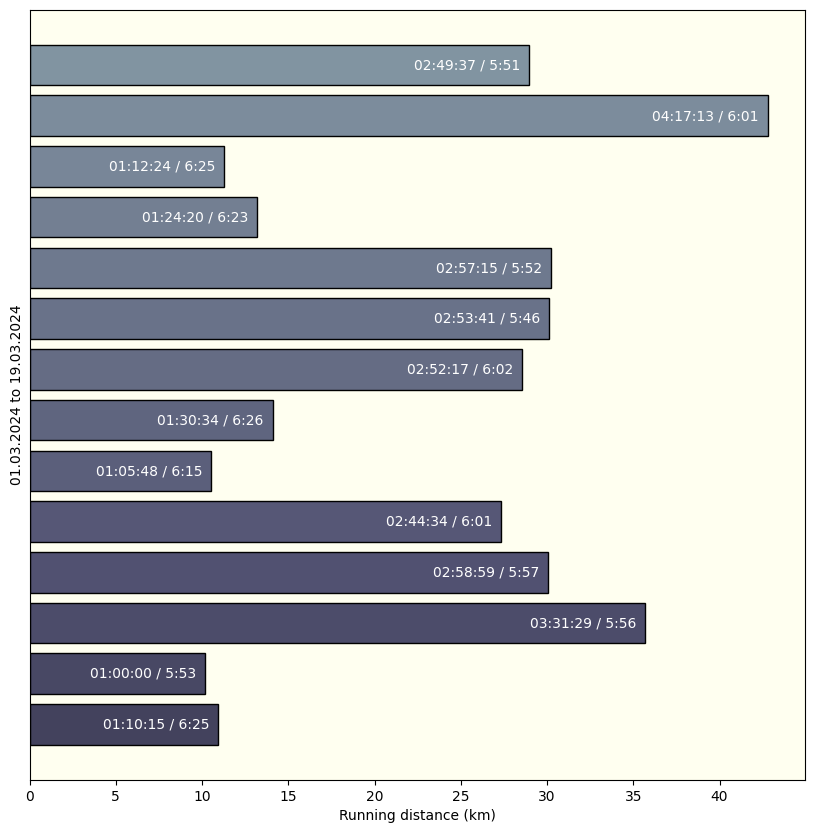

In [385]:
# Main function
def main():
    activities = extract_activity_data()
    if not activities.empty:  # Check if activities is not empty
        create_chart(activities)
        create_video(activities)
    else:
        print("No activities found.")

if __name__ == "__main__":
    main()